# Data processing: step 3

Make cuts on the events, define a signal region, split into train-test, preprocess

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from helpers.plotting import *


In [25]:
codes_list = ["cmssim"]#, "zmm_forcms_1k-mz90.1-mw80.4_full"]#, "sim_zmm_forcms_1k-mz90.1-mw80.4_8000030"]

uncut_data = {}
for code in codes_list:
    uncut_data[code] = np.load(f"compiled_data/{code}.npy")
    
    uncut_data[code] = np.nan_to_num(uncut_data[code])
        
    print(f"{code} has initial shape {uncut_data[code].shape}")

cmssim has initial shape (247767, 13)


## Visualize the data

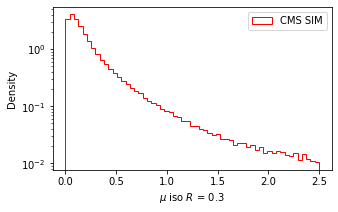

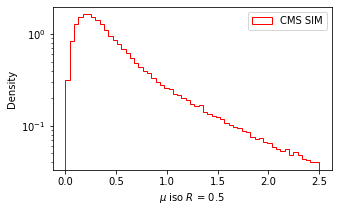

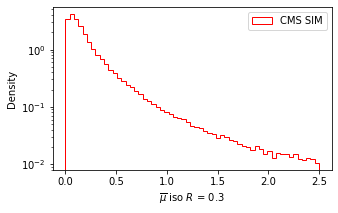

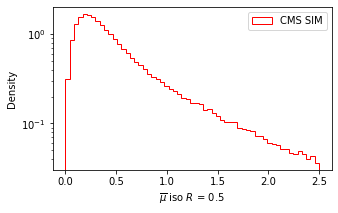

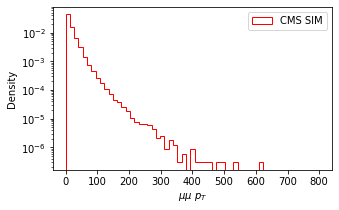

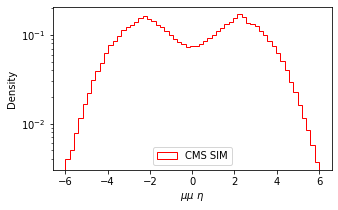

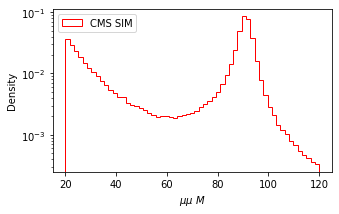

In [26]:
feature_set = [5, 6, 7, 8, 9, 10, 12]
    
hist_all_features(codes_list, uncut_data, feature_set, kwargs_dict_dtype)
    




## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)

In [17]:
# jet_cuts

jet_pt_cut = 15 
jet_eta_cut = 2.4

cut_data = {}
for code in codes_list:
    
    # pt_cut, eta cut on the jets
    pass_indices = (uncut_data[code][:,0] > jet_pt_cut) & (np.abs(uncut_data[code][:,1]) < jet_eta_cut) # MAKE SURE THE INDICES ARE OK
    cut_data[code] = uncut_data[code][pass_indices]
    print(f"{code} has shape {cut_data[code].shape} after cuts")
    

    

cmssim has shape (191308, 13) after cuts


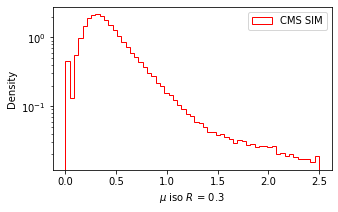

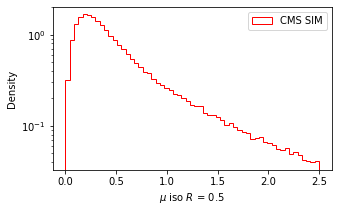

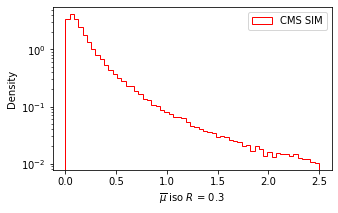

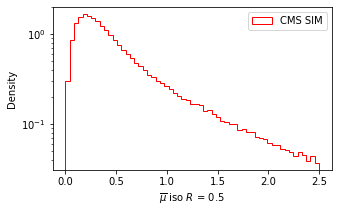

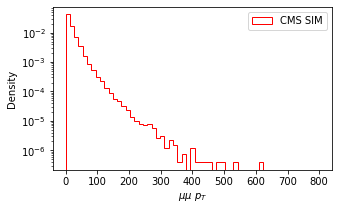

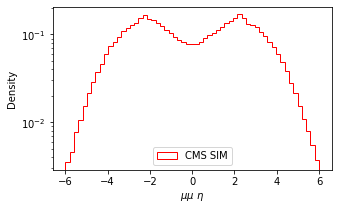

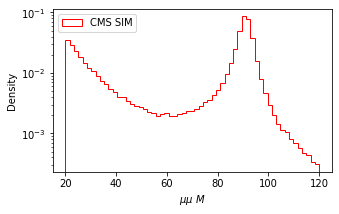

In [18]:
    
    
hist_all_features(codes_list, cut_data, feature_set, kwargs_dict_dtype, image_path = "plots/sim_v_od")
    

## Define SR / SB

Signal region can be anywhere from 10 - 90 geV

In [19]:
band_bounds = {"SBL": [15, 40],
               "IBL": [40, 50],
               "SR": [50, 70],
               "IBH": [70, 75],
               "SBH": [75, 85],
                       }

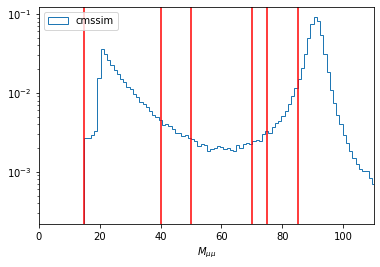

In [20]:
plt.figure()

for code in codes_list:
    plt.hist(cut_data[code][:,-1], bins = np.linspace(15, 120, 100), histtype = "step", density = "True", label = code)

plt.legend()
plt.axvline(band_bounds["SBL"][0], color= "red")
plt.axvline(band_bounds["IBL"][0], color= "red")
plt.axvline(band_bounds["SR"][0], color= "red")
plt.axvline(band_bounds["IBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][0], color= "red")
plt.axvline(band_bounds["SBH"][1], color= "red")

plt.xlabel("$M_{\mu\mu}$")

plt.xlim(0, 110)
plt.yscale("log")
plt.show()

In [21]:
SR_data_preprocc = {}
SBL_data_preprocc = {} # sideband low
SBH_data_preprocc = {} # sideband high
IBL_data_preprocc = {} # innerband low
IBH_data_preprocc = {} # innerband high

bands = ["SBL", "IBL", "SR", "IBH", "SBH"]

preproc_dicts = {b:{} for b in bands}


for code in codes_list:
    
    for b in bands:

        loc_pass_indices = (cut_data[code][:,-1] > band_bounds[b][0]) & (cut_data[code][:,-1] < band_bounds[b][1])
        preproc_dicts[b][code] = cut_data[code][loc_pass_indices]

        print(f"{code} {b} has shape {preproc_dicts[b][code].shape}")
   
    
    

cmssim SBL has shape (55383, 13)
cmssim IBL has shape (6078, 13)
cmssim SR has shape (7653, 13)
cmssim IBH has shape (2428, 13)
cmssim SBH has shape (10570, 13)


In [22]:
#hist_all_features(codes_list, SR_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB1_data_preprocc, kwargs_dict, feature_bins)
#hist_all_features(codes_list, SB2_data_preprocc, kwargs_dict, feature_bins)

## Preprocessing

Standard scaling is fine

In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

proc_dicts = {b:{} for b in bands}

for code in codes_list:
    
    SB_all = np.vstack((preproc_dicts["SBL"][code], preproc_dicts["SBH"][code]))
    scaler = StandardScaler()
    scaler = scaler.fit(SB_all)
    
    for b in bands:
    
        proc_dicts[b][code] = scaler.transform(preproc_dicts[b][code])




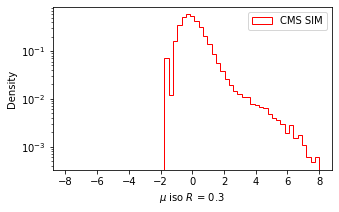

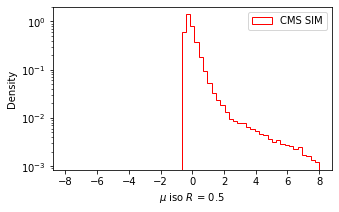

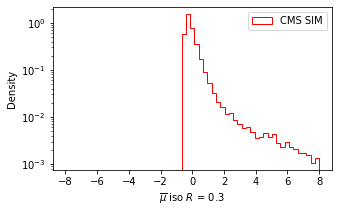

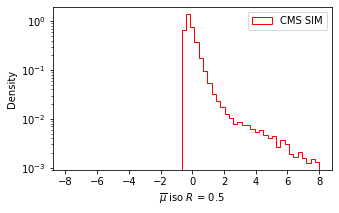

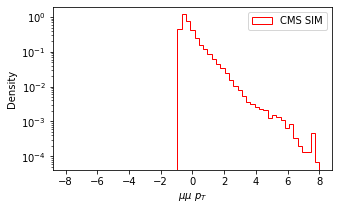

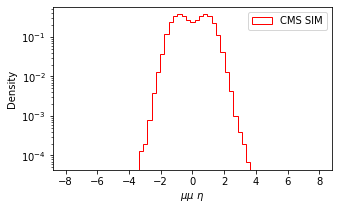

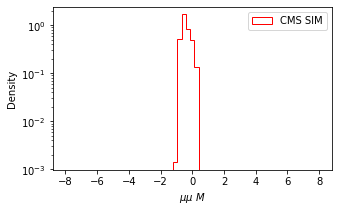

In [24]:
hist_all_features(codes_list, proc_dicts["SBL"], feature_set, kwargs_dict_dtype, scaled_features = True)


In [12]:
#hist_all_features(codes_list, SB_data_procc, kwargs_dict, scaled_bins)


In [13]:
for code in codes_list:

    for b in bands:
    
        np.save(f"processed_data/{code}_{b}_minmax.npy", proc_dicts[b][code])

